In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import matplotlib as mpl
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

In [168]:
df = pd.read_csv('./../p_lungcancer_all_add2.csv')
df2 = df.copy()

In [169]:
df.Stage.value_counts()

Stage
Stage 4    7151
Stage 1    3338
Stage 3    2765
Stage 2    1743
Stage 0       3
Name: count, dtype: int64

In [170]:
df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2

In [171]:
df.head()

,AGE,Stage,Tumor_Size,lymph_node_meta_size,Adenocarcinoma,Large_cell_carcinoma,Squamous_cell_carcinoma,TX,T0,T1,...,Death,Survival_period,EGFR_0,EGFR_1,EGFR_99,Drink_1,Drink_2,Drink_3,Drink_99,BMI
0,72,Stage 1,0.0,0.0,1,1,0,1,0,0,...,0,157,False,False,True,False,False,False,True,33.822654
1,66,Stage 4,2.0,4.5,1,0,0,0,0,1,...,0,567,False,False,True,False,False,False,True,18.984376
2,75,Stage 4,0.0,0.0,1,1,0,1,0,0,...,0,253,False,False,True,False,False,True,False,25.596524
3,77,Stage 4,2.0,8.0,1,0,1,0,0,1,...,0,266,False,True,False,False,True,False,False,31.486033
4,85,Stage 1,2.5,0.0,1,0,0,0,0,0,...,0,470,False,False,True,False,True,False,False,14.922211


In [172]:
#T0는 종양이 존재하지 않음을 의미. 즉, 종양이 없다는 정보이기 때문에 다른 T 값들과 합산하면 의미가 왜곡될 우려 있음.
#TX는 종양의 크기를 정확하게 알 수 없다는 의미, 사실상 정보가 없다고 볼 수 있음. 
# 따라서 TX를 다른 T 값들과 합산하면 제대로 된 의미를 갖지 못함.
# T0와 TX는 제외하고 T1~T4 값만 합산
df['T_sum'] = df[['T1', 'T1a', 'T1b', 'T1c', 'T2', 'T2a', 'T2b', 'T3', 'T4']].sum(axis=1)

In [173]:
# 각 T 항목에 대해 사이즈 곱하기
df['T_sized_sum'] = (df['T1'] * 2 +
                        df['T1a'] * 0.5 +
                        df['T1b'] * 1.5 +
                        df['T1c'] * 2.5 +
                        df['T2'] * 4 +
                        df['T2a'] * 3.5 +
                        df['T2b'] * 4.5 +
                        df['T3'] * 6 +
                        df['T4'] * 8.5)

In [174]:
# 각 N 항목에 대해 원하는 사이즈 곱하기 (2, 4.5, 8)
df['N_sized_sum'] = (df['N1'] * 2 +
                        df['N2'] * 4.5 +
                        df['N3'] * 8)

In [175]:
# N 항목 합산하기
df['N_sum'] = df['N1'] + df['N2'] + df['N3']

In [176]:
# M 항목 합산하기
df['M_sum'] = df['M1a'] + df['M1b'] + df['M1c']

In [177]:
# 각 T 항목에 대해 원하는 가중치 곱하기
df['T_weighted_sum'] = (df['T1'] * 1 +
                        df['T1a'] * 1 +
                        df['T1b'] * 1 +
                        df['T1c'] * 1 +
                        df['T2'] * 1 +
                        df['T2a'] * 1 +
                        df['T2b'] * 1 +
                        df['T3'] * 2 +
                        df['T4'] * 3)



In [178]:
# 각 N 항목에 대해 원하는 가중치 곱하기 (2, 2.5,3)
df['N_weighted_sum'] = (df['N1'] * 2 +
                        df['N2'] * 2.5 +
                        df['N3'] * 3)

In [179]:
# 각 M 항목에 대해 원하는 가중치 곱하기 (3,4,5)
df['M_weighted_sum'] = (df['M1a'] * 3 +
                        df['M1b'] * 4 +
                        df['M1c'] * 5)

In [180]:
df.head()

,AGE,Stage,Tumor_Size,lymph_node_meta_size,Adenocarcinoma,Large_cell_carcinoma,Squamous_cell_carcinoma,TX,T0,T1,...,Drink_99,BMI,T_sum,T_sized_sum,N_sized_sum,N_sum,M_sum,T_weighted_sum,N_weighted_sum,M_weighted_sum
0,72,Stage 1,0.0,0.0,1,1,0,1,0,0,...,True,33.822654,0,0.0,0.0,0,0,0,0.0,0
1,66,Stage 4,2.0,4.5,1,0,0,0,0,1,...,True,18.984376,1,2.0,4.5,1,1,1,2.5,4
2,75,Stage 4,0.0,0.0,1,1,0,1,0,0,...,False,25.596524,0,0.0,0.0,0,1,0,0.0,4
3,77,Stage 4,2.0,8.0,1,0,1,0,0,1,...,False,31.486033,1,2.0,10.0,2,1,1,5.0,3
4,85,Stage 1,2.5,0.0,1,0,0,0,0,0,...,False,14.922211,1,2.5,0.0,0,0,1,0.0,0


In [181]:
from sklearn.preprocessing import OrdinalEncoder

# 'stage' 컬럼에 대해 순서 지정 (1기 → 4기)
stage_order = [['Stage 0','Stage 1', 'Stage 2', 'Stage 3', 'Stage 4']]

# OrdinalEncoder 객체 생성 및 적용
encoder = OrdinalEncoder(categories=stage_order)
df['Stage'] = encoder.fit_transform(df[['Stage']])

In [182]:
df.head()

,AGE,Stage,Tumor_Size,lymph_node_meta_size,Adenocarcinoma,Large_cell_carcinoma,Squamous_cell_carcinoma,TX,T0,T1,...,Drink_99,BMI,T_sum,T_sized_sum,N_sized_sum,N_sum,M_sum,T_weighted_sum,N_weighted_sum,M_weighted_sum
0,72,1.0,0.0,0.0,1,1,0,1,0,0,...,True,33.822654,0,0.0,0.0,0,0,0,0.0,0
1,66,4.0,2.0,4.5,1,0,0,0,0,1,...,True,18.984376,1,2.0,4.5,1,1,1,2.5,4
2,75,4.0,0.0,0.0,1,1,0,1,0,0,...,False,25.596524,0,0.0,0.0,0,1,0,0.0,4
3,77,4.0,2.0,8.0,1,0,1,0,0,1,...,False,31.486033,1,2.0,10.0,2,1,1,5.0,3
4,85,1.0,2.5,0.0,1,0,0,0,0,0,...,False,14.922211,1,2.5,0.0,0,0,1,0.0,0


In [183]:
#Smoke에 원핫 인코딩하기
df = pd.get_dummies(data = df, columns=['Smoke'], drop_first=True)

In [184]:
#범주형을 제외한 컬럼에 정규화
'''from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['Tumor_Size', 'lymph_node_meta_size','Height','Weight','FEV1_FVC_P',
        'DLCO_VA_P','AGE','Survival_period','BMI', 
        'T_sum','N_sum','M_sum','T_weighted_sum','N_weighted_sum','M_weighted_sum','T_sized_sum','N_sized_sum']] = scaler.fit_transform(df[['Tumor_Size', 'lymph_node_meta_size','Height','Weight',
                           'FEV1_FVC_P','DLCO_VA_P','AGE','Survival_period','BMI',
                          'T_sum','N_sum','M_sum',
                           'T_weighted_sum','N_weighted_sum','M_weighted_sum','T_sized_sum','N_sized_sum']])
'''

"from sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\ndf[['Tumor_Size', 'lymph_node_meta_size','Height','Weight','FEV1_FVC_P',\n        'DLCO_VA_P','AGE','Survival_period','BMI', \n        'T_sum','N_sum','M_sum','T_weighted_sum','N_weighted_sum','M_weighted_sum','T_sized_sum','N_sized_sum']] = scaler.fit_transform(df[['Tumor_Size', 'lymph_node_meta_size','Height','Weight',\n                           'FEV1_FVC_P','DLCO_VA_P','AGE','Survival_period','BMI',\n                          'T_sum','N_sum','M_sum',\n                           'T_weighted_sum','N_weighted_sum','M_weighted_sum','T_sized_sum','N_sized_sum']])\n"

In [185]:
#df 컬럼 확인
df.columns

Index(['AGE', 'Stage', 'Tumor_Size', 'lymph_node_meta_size', 'Adenocarcinoma',
       'Large_cell_carcinoma', 'Squamous_cell_carcinoma', 'TX', 'T0', 'T1',
       'T1a', 'T1b', 'T1c', 'T2', 'T2a', 'T2b', 'T3', 'T4', 'N0', 'N1', 'N2',
       'N3', 'M0', 'M1a', 'M1b', 'M1c', 'Height', 'Weight', 'FEV1_FVC_P',
       'DLCO_VA_P', 'Operation', 'Chemotherapy', 'Radiation_Therapy', 'Death',
       'Survival_period', 'EGFR_0', 'EGFR_1', 'EGFR_99', 'Drink_1', 'Drink_2',
       'Drink_3', 'Drink_99', 'BMI', 'T_sum', 'T_sized_sum', 'N_sized_sum',
       'N_sum', 'M_sum', 'T_weighted_sum', 'N_weighted_sum', 'M_weighted_sum',
       'Smoke_1', 'Smoke_2'],
      dtype='object')

In [186]:
#Train data set 분리
df_train = df.iloc[0:10000]

In [187]:
#Test data set 분리
df_test = df.iloc[10000:15000]

In [188]:
# Test data set에 대한 reset index 실행
df_test.reset_index(drop=True, inplace=True)

In [189]:
df_test.head()

,AGE,Stage,Tumor_Size,lymph_node_meta_size,Adenocarcinoma,Large_cell_carcinoma,Squamous_cell_carcinoma,TX,T0,T1,...,T_sum,T_sized_sum,N_sized_sum,N_sum,M_sum,T_weighted_sum,N_weighted_sum,M_weighted_sum,Smoke_1,Smoke_2
0,35,4.0,4.0,0.0,1,0,0,0,0,0,...,1,4.0,0.0,0,1,1,0.0,4,True,False
1,60,2.0,1.5,2.0,1,0,0,0,0,0,...,1,1.5,2.0,1,0,1,2.0,0,False,False
2,45,4.0,0.0,2.0,1,1,1,1,0,0,...,0,0.0,2.0,1,1,0,2.0,5,False,False
3,31,4.0,0.0,2.0,0,0,0,1,0,0,...,0,0.0,2.0,1,1,0,2.0,3,True,False
4,55,3.0,0.5,8.0,0,0,1,0,0,0,...,1,0.5,8.0,1,0,1,3.0,0,True,False


In [190]:
df.head()

,AGE,Stage,Tumor_Size,lymph_node_meta_size,Adenocarcinoma,Large_cell_carcinoma,Squamous_cell_carcinoma,TX,T0,T1,...,T_sum,T_sized_sum,N_sized_sum,N_sum,M_sum,T_weighted_sum,N_weighted_sum,M_weighted_sum,Smoke_1,Smoke_2
0,72,1.0,0.0,0.0,1,1,0,1,0,0,...,0,0.0,0.0,0,0,0,0.0,0,False,True
1,66,4.0,2.0,4.5,1,0,0,0,0,1,...,1,2.0,4.5,1,1,1,2.5,4,False,True
2,75,4.0,0.0,0.0,1,1,0,1,0,0,...,0,0.0,0.0,0,1,0,0.0,4,False,True
3,77,4.0,2.0,8.0,1,0,1,0,0,1,...,1,2.0,10.0,2,1,1,5.0,3,False,True
4,85,1.0,2.5,0.0,1,0,0,0,0,0,...,1,2.5,0.0,0,0,1,0.0,0,False,True


In [191]:
df_train2 = df_train.copy()

In [192]:
df_train.Death.value_counts()

Death
0    7897
1    2103
Name: count, dtype: int64

In [193]:
df_test.Death.value_counts()

Death
0    3089
1    1911
Name: count, dtype: int64

In [194]:
#Train Classifier data set - X
train_C_x = df_train.drop(columns=['Death','Drink_1','Drink_2','Drink_3','Drink_99','EGFR_99',
                                   'T1', 'T1a', 'T1b', 'T1c', 'T2', 'T2a', 'T2b', 'T3', 'T4', 'N1', 'N2', 'N3', 'M1a', 'M1b', 'M1c' ], axis=1)

In [195]:
#Train Classifier data set - Target
train_C_y = df_train.Death.values

In [196]:
train_C_x.shape

(10000, 32)

In [197]:
#Test Classifier data set - X
test_C_x = df_test.drop(columns=['Death','Drink_1','Drink_2','Drink_3','Drink_99','EGFR_99',
                                 'T1', 'T1a', 'T1b', 'T1c', 'T2', 'T2a', 'T2b', 'T3', 'T4', 'N1', 'N2', 'N3', 'M1a', 'M1b', 'M1c' ], axis=1)

In [198]:
##Test Classifier data set - target
test_C_y = df_test.Death.values

In [199]:
test_C_y.shape

(5000,)

In [200]:
train_C_x

,AGE,Stage,Tumor_Size,lymph_node_meta_size,Adenocarcinoma,Large_cell_carcinoma,Squamous_cell_carcinoma,TX,T0,N0,...,T_sum,T_sized_sum,N_sized_sum,N_sum,M_sum,T_weighted_sum,N_weighted_sum,M_weighted_sum,Smoke_1,Smoke_2
0,72,1.0,0.0,0.0,1,1,0,1,0,1,...,0,0.0,0.0,0,0,0,0.0,0,False,True
1,66,4.0,2.0,4.5,1,0,0,0,0,0,...,1,2.0,4.5,1,1,1,2.5,4,False,True
2,75,4.0,0.0,0.0,1,1,0,1,0,1,...,0,0.0,0.0,0,1,0,0.0,4,False,True
3,77,4.0,2.0,8.0,1,0,1,0,0,0,...,1,2.0,10.0,2,1,1,5.0,3,False,True
4,85,1.0,2.5,0.0,1,0,0,0,0,1,...,1,2.5,0.0,0,0,1,0.0,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,69,4.0,1.5,0.0,1,0,0,0,0,1,...,1,1.5,0.0,0,1,1,0.0,4,True,False
9996,37,4.0,0.5,4.5,0,0,0,0,0,0,...,1,0.5,4.5,1,1,1,2.5,5,True,False
9997,31,1.0,0.5,0.0,1,0,0,0,0,1,...,1,0.5,0.0,0,0,1,0.0,0,False,True
9998,85,3.0,8.5,0.0,0,0,0,0,0,1,...,1,8.5,0.0,0,0,3,0.0,0,False,True


In [322]:
pip install catboost


   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.1/101.7 MB 1.1 MB/s eta 0:01:34
   ---------------------------------------- 0.7/101.7 MB 7.5 MB/s eta 0:00:14
    --------------------------------------- 2.1/101.7 MB 14.7 MB/s eta 0:00:07
   - -------------------------------------- 2.8/101.7 MB 14.8 MB/s eta 0:00:07
   - -------------------------------------- 3.2/101.7 MB 14.6 MB/s eta 0:00:07
   -- ------------------------------------- 6.3/101.7 MB 22.3 MB/s eta 0:00:05
   --- ------------------------------------ 8.6/101.7 MB 26.3 MB/s eta 0:00:04
   ---- ----------------------------------- 11.0/101.7 MB 36.4 MB/s eta 0:00:03
   ----- ---------------------------------- 13.3/101.7 MB 50.4 MB/s eta 0:00:02
   ------ --------------------------------- 15.8/101.7 MB 50.4 MB/s eta 0:00:02
   ------- -------------------------------- 18.2/101.7 MB 50.4 MB/

In [202]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import ElasticNet

# Custom transformer to apply weights
class WeightTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, t_weight=(1, 2, 3, 4), n_weight=(0, 1, 2), m_weight=(0, 1, 2)):
        self.t_weight = t_weight
        self.n_weight = n_weight
        self.m_weight = m_weight

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # 가중치를 적용한 새로운 열 생성
        X['T_weighted'] = (X['T1'] * self.t_weight[0] + 
                           X['T1a'] * self.t_weight[0] + 
                           X['T1b'] * self.t_weight[0] + 
                           X['T1c'] * self.t_weight[0] + 
                           X['T2'] * self.t_weight[1] + 
                           X['T2a'] * self.t_weight[1] + 
                           X['T2b'] * self.t_weight[1] + 
                           X['T3'] * self.t_weight[2] +
                           X['T4'] * self.t_weight[3])
        X['N_weighted'] = (X['N1'] * self.n_weight[0] +
                           X['N2'] * self.n_weight[1] + 
                           X['N3'] * self.n_weight[2])
        X['M_weighted'] = (X['M1a'] * self.m_weight[0] + 
                           X['M1b'] * self.m_weight[1] +
                           X['M1c'] * self.m_weight[2])
        #return X.drop(columns=['T1', 'T1a', 'T1b', 'T1c', 'T2', 'T2a', 'T2b', 'T3', 'T4', 'N1', 'N2', 'N3', 'M1a', 'M1b', 'M1c'])
        return X

# 파이프라인 구성
pipeline = Pipeline([
    #('weight_transform', WeightTransformer()),  # 가중치 적용
    #('scaler', StandardScaler()),
    #('anova', SelectKBest(score_func=f_classif)),
    #('elasticnet', ElasticNet())   # 엘라스틱넷 모델
    #('pca', PCA(n_components=4)),
    #('lda', LinearDiscriminantAnalysis()),
    #('classifier', LogisticRegression( ))        # 로지스틱 회귀 모델
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42 ))  
    #('classifier', KNeighborsClassifier(n_neighbors=6))
    #('classifier', xgb.XGBClassifier())
    #('classifier', DecisionTreeClassifier(random_state=42))
    #('classifier',SVC(kernel='linear', C=1, random_state=42,class_weight='balanced' ))
    #('classifier',lgb.LGBMClassifier(random_state=42))
    #('classifier',CatBoostClassifier(random_state=42, verbose=0,class_weights=[1, 3] ))
    #('ridge', Ridge(alpha=1.0))
    

])

# Grid Search를 위한 파라미터 그리드 설정
param_grid = {
    #'weight_transform__t_weight': [(1, 2, 3, 4)],
    #'weight_transform__n_weight': [ (1, 2, 3)],
    #'weight_transform__m_weight': [(0, 2, 4)],
    #'classifier__C': [0.1,0.5, 1]  # 로지스틱 회귀의 정규화 강도
    #'pca__n_components': [3,5,7,10,12,15,20],
    #'lda__n_components': [1],  # LDA 차원 축소 개수
    #'lda__solver': [ 'lsqr'],  # LDA 해결 방법
    #'lda__shrinkage': ['auto', None],  # 'lsqr' 방법에서 사용 가능한 옵션
    #'ridge__alpha': [0.01, 0.1, 1, 5, 10, 50, 100]
    'classifier__n_estimators': [100],  # 랜덤 포레스트의 결정 트리 수
    'classifier__max_depth': [6, 20],  # 트리의 최대 깊이
    #'anova__k': [5, 10, 15,20, 25]
    #'elasticnet__alpha': [0.3, 0.5, 1.0, 5.0],  # 규제 강도
    #'elasticnet__l1_ratio': [0.1, 0.5, 0.7, 1.0],  # L1과 L2 비율
}

# GridSearchCV 실행
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy' ,n_jobs=-1)
grid_search.fit(train_C_x, train_C_y)

# 최적의 파라미터 출력
print("최적의 가중치:", grid_search.best_params_)
print("최고 정확도:", grid_search.best_score_)

최적의 가중치: {'classifier__max_depth': 6, 'classifier__n_estimators': 100}
최고 정확도: 0.7897


In [56]:
train_C_x.shape

(10000, 32)

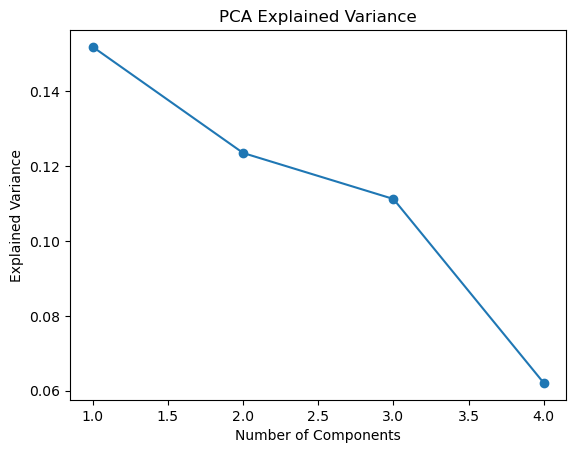

In [57]:
# PCA 객체 추출
pca = grid_search.best_estimator_.named_steps['pca']

# 설명된 분산 비율 추출
explained_variance = pca.explained_variance_ratio_

# 그래프 그리기
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('PCA Explained Variance')
plt.show()



In [58]:
# 누적 설명된 분산 비율 계산
cumulative_variance = explained_variance.cumsum()

# 95% 이상 설명하는 주성분 수 선택
n_components = (cumulative_variance >= 0.95).argmax() + 1
print(f"95% 이상 설명하는 주성분 수: {n_components}")

# 급격히 꺾이는 지점의 인덱스 확인
elbow_point = np.argmax(np.diff(cumulative_variance) < 0.05) + 1  # 급격히 꺾이는 부분 찾기
print("급격히 꺾이는 지점(주성분 개수):", elbow_point)

95% 이상 설명하는 주성분 수: 1
급격히 꺾이는 지점(주성분 개수): 1


In [59]:
# PCA에서 주성분 확인
pca_components = pca.components_
pca_df = pd.DataFrame(pca_components, columns=train_C_x.columns)
# 첫 번째 주성분(주 성분 벡터)을 확인
first_component = pca_components[0]

# 첫 번째 주성분의 피처별 가중치 (즉, 중요도)
print("첫 번째 주성분:", first_component)

첫 번째 주성분: [-3.58565005e-04  2.67755829e-01  2.88737215e-02  4.18179160e-01
  1.48457905e-04  8.03794452e-03 -2.14482039e-03 -2.11335448e-02
 -4.29322564e-03 -4.12806116e-01 -1.08871038e-01 -1.14882854e-02
  8.51675531e-03 -1.14700538e-03  2.59062420e-03 -5.54923263e-03
  4.95302003e-03  4.13519356e-03 -8.17207388e-03  3.00399586e-03
  3.70505251e-03  1.31102247e-02  2.21324385e-02  2.88737215e-02
  4.18728580e-01  4.22926409e-01  1.08871038e-01  2.98651462e-02
  4.35537614e-01  1.06221656e-01  1.48595509e-03  3.11820450e-03]


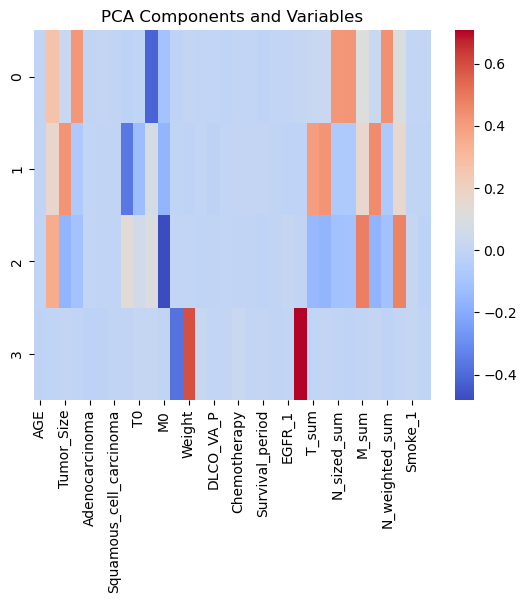

In [60]:
# PCA 성분을 히트맵으로 시각화
sns.heatmap(pca_df, annot=False, cmap="coolwarm")
plt.title("PCA Components and Variables")
plt.show()

In [203]:
# GridSearchCV에서 최적의 모델 추출
best_model = grid_search.best_estimator_
from sklearn.metrics import confusion_matrix

In [205]:
# 예측 결과
y_pred = best_model.predict(test_C_x)

In [112]:
test_C_x.shape

(5000, 47)

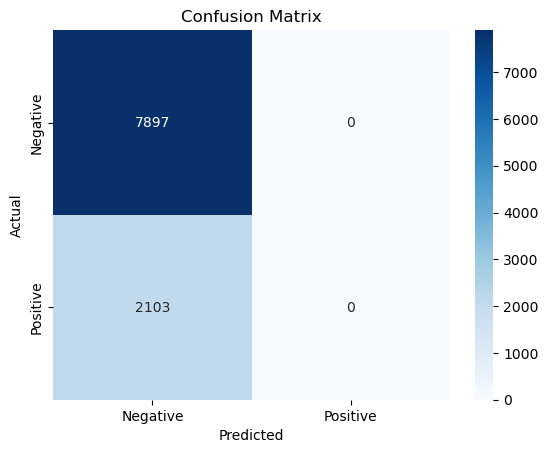

Accuracy: 0.7897
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


c:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [204]:
# trainset 결과
y_pred = best_model.predict(train_C_x)

# 혼동 행렬 계산
cm = confusion_matrix(train_C_y, y_pred)

# 시각화
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Accuracy, Precision, Recall, F1 Score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy:", accuracy_score(train_C_y, y_pred))
print("Precision:", precision_score(train_C_y, y_pred))
print("Recall:", recall_score(train_C_y, y_pred))
print("F1 Score:", f1_score(train_C_y, y_pred))

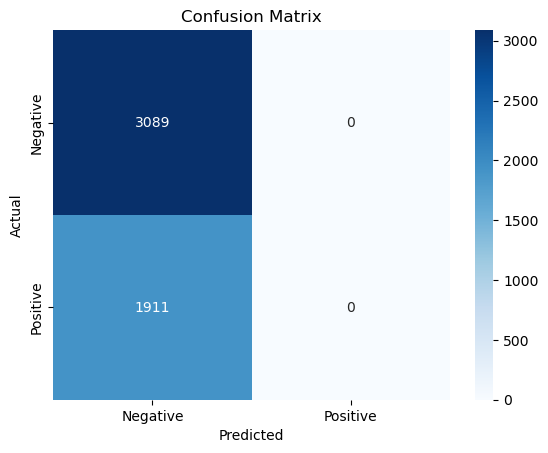

Accuracy: 0.6178
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


c:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [206]:
# 예측 결과
y_pred = best_model.predict(test_C_x)

# 혼동 행렬 계산
cm = confusion_matrix(test_C_y, y_pred)

# 시각화
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Accuracy, Precision, Recall, F1 Score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy:", accuracy_score(test_C_y, y_pred))
print("Precision:", precision_score(test_C_y, y_pred))
print("Recall:", recall_score(test_C_y, y_pred))
print("F1 Score:", f1_score(test_C_y, y_pred))

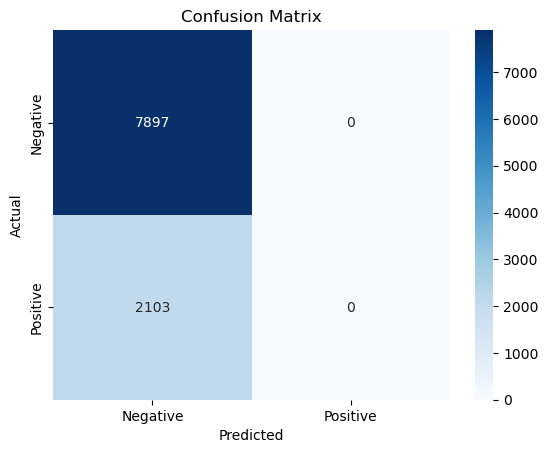

Accuracy: 0.7897
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


c:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [207]:
# trainset 결과
y_pred = best_model.predict(train_C_x)

# 혼동 행렬 계산
cm = confusion_matrix(train_C_y, y_pred)

# 시각화
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Accuracy, Precision, Recall, F1 Score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy:", accuracy_score(train_C_y, y_pred))
print("Precision:", precision_score(train_C_y, y_pred))
print("Recall:", recall_score(train_C_y, y_pred))
print("F1 Score:", f1_score(train_C_y, y_pred))

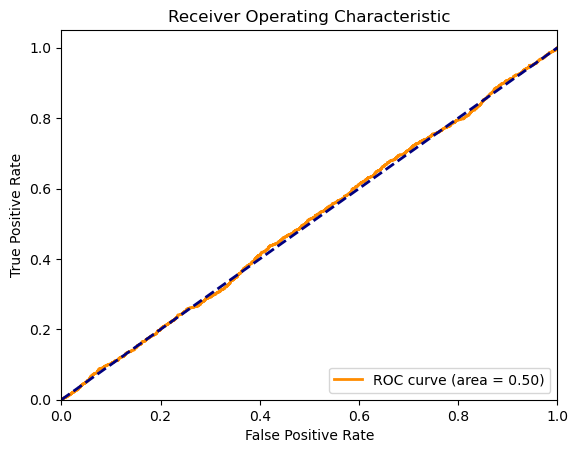

In [65]:
from sklearn.metrics import roc_curve, auc
y_prob = best_model.predict_proba(test_C_x)[:, 1]  # 긍정 클래스 확률만 사용

#y_prob = best_model.named_steps['classifier'].predict_proba(test_C_x)[:, 1]  

# ROC 커브 계산
fpr, tpr, thresholds = roc_curve(test_C_y, y_prob)
roc_auc = auc(fpr, tpr)

# ROC 커브 시각화
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [459]:
test_C_x.shape

(5000, 47)

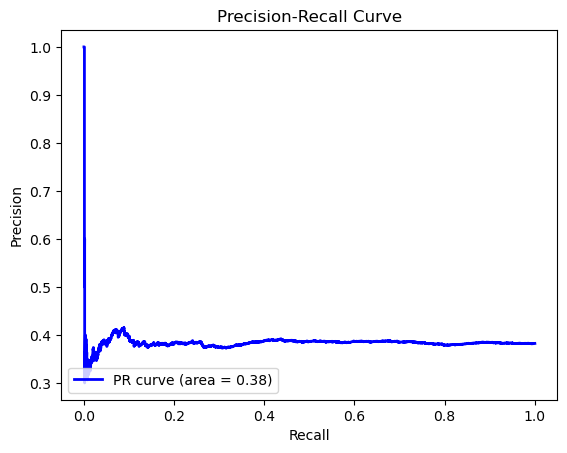

In [66]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# PR 커브 계산
precision, recall, _ = precision_recall_curve(test_C_y, y_prob)
auc_pr = average_precision_score(test_C_y, y_prob)

# PR 커브 시각화
plt.figure()
plt.plot(recall, precision, color='b', lw=2, label='PR curve (area = %0.2f)' % auc_pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [304]:
grid_search.best_params_

{'weight_transform__m_weight': (0, 2, 4),
 'weight_transform__n_weight': (0, 1, 2),
 'weight_transform__t_weight': (1, 2, 3, 4)}

['AGE', 'Stage', 'Tumor_Size', 'lymph_node_meta_size', 'Adenocarcinoma', 'Large_cell_carcinoma', 'Squamous_cell_carcinoma', 'TX', 'T0', 'N0', 'M0', 'Height', 'Weight', 'FEV1_FVC_P', 'DLCO_VA_P', 'Operation', 'Chemotherapy', 'Radiation_Therapy', 'Survival_period', 'EGFR_0', 'EGFR_1', 'BMI', 'T_sum', 'T_sized_sum', 'N_sized_sum', 'N_sum', 'M_sum', 'T_weighted_sum', 'N_weighted_sum', 'M_weighted_sum', 'Smoke_1', 'Smoke_2']
32
4


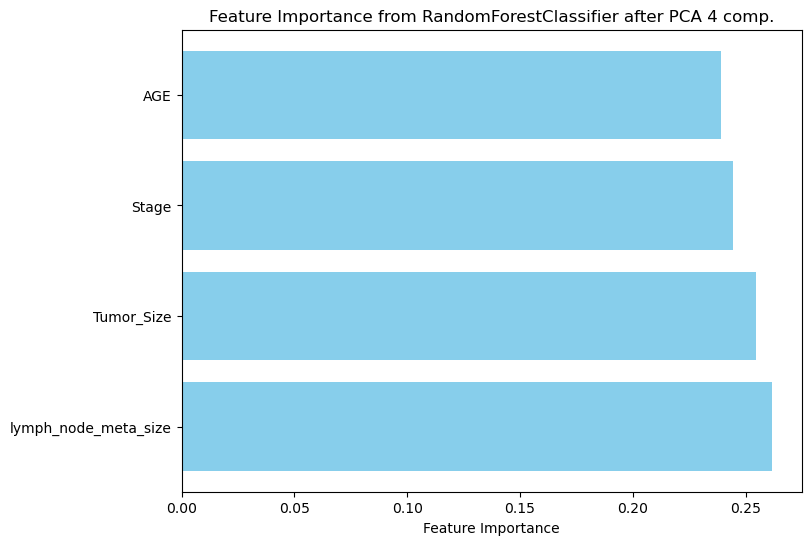

In [69]:

# GridSearch에서 최적의 모델을 추출
best_pipeline = grid_search.best_estimator_

# RandomForestClassifier 모델 추출
best_model = best_pipeline.named_steps['classifier']

# 'weight_transform' 단계의 결과를 출력
#transformed_data = best_pipeline.named_steps['weight_transform'].transform(train_C_x)

# 변환된 데이터의 컬럼을 출력
#print(transformed_data.columns)


# Feature 이름 가져오기 (변환된 데이터셋 기준)

#original_feature_names = list(train_C_x.drop(columns=['T1', 'T1a', 'T1b', 'T1c', 'T2', 'T2a', 'T2b', 'T3', 'T4', 'N1', 'N2', 'N3', 'M1a', 'M1b', 'M1c'],axis=1)) 
original_feature_names = list(train_C_x.columns) 
#weighted_features = ['T_weighted', 'N_weighted', 'M_weighted']
#final_feature_names = original_feature_names
print(original_feature_names)
print(len(original_feature_names))

# Feature Importance 계산
importances = best_model.feature_importances_
print(len(importances))

# Feature Importance 시각화
plt.figure(figsize=(8, 6))
indices = np.argsort(importances)[::-1]
plt.barh(np.array(original_feature_names)[indices], importances[indices], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance from RandomForestClassifier after PCA 4 comp.")
#plt.title("Feature Importance from XGBost")
plt.show()

In [208]:
#rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [209]:
#랜덤포레스트 모델 훈련 및 정확도
#rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_C_x, train_C_y)

y_pred = rf_model.predict(test_C_x)
rf_model.score(test_C_x, test_C_y) # r2 값과 동일

0.6182

In [210]:
#feature importance 계산해보기 (모델의 특성이 얼마나 예측에 중요한지 확인해보기)
feature_importance = rf_model.feature_importances_

sorted_idx = feature_importance.argsort()
print(sorted_idx)

[ 8 22  9  7 10 26 25 30 20 27 19  5  3 28 31 24  1 17  6  4 16 15 29 23
  2  0 13 14 12 11 18 21]


In [211]:
train_C_x.columns

Index(['AGE', 'Stage', 'Tumor_Size', 'lymph_node_meta_size', 'Adenocarcinoma',
       'Large_cell_carcinoma', 'Squamous_cell_carcinoma', 'TX', 'T0', 'N0',
       'M0', 'Height', 'Weight', 'FEV1_FVC_P', 'DLCO_VA_P', 'Operation',
       'Chemotherapy', 'Radiation_Therapy', 'Survival_period', 'EGFR_0',
       'EGFR_1', 'BMI', 'T_sum', 'T_sized_sum', 'N_sized_sum', 'N_sum',
       'M_sum', 'T_weighted_sum', 'N_weighted_sum', 'M_weighted_sum',
       'Smoke_1', 'Smoke_2'],
      dtype='object')

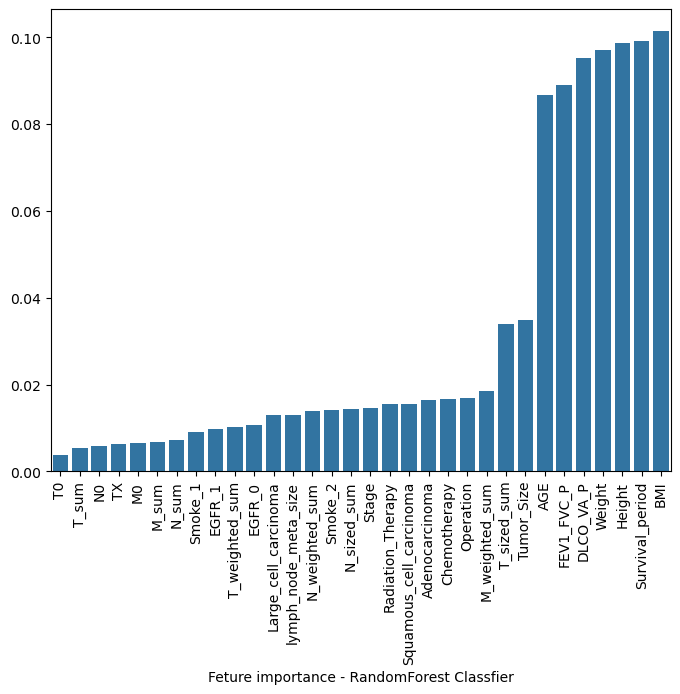

In [212]:

train_x_columns=train_C_x.columns[sorted_idx]
plt.figure(figsize=(8,6))
sns.barplot(x=train_x_columns, y=feature_importance[sorted_idx], )
plt.xticks(rotation=90)
plt.xlabel('Feture importance - RandomForest Classfier')
plt.show()

In [213]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf_model, train_C_x, train_C_y, n_repeats=10)
importance = result.importances_mean
print(importance)


[6.532e-02 9.470e-03 2.404e-02 1.480e-03 3.910e-03 6.480e-03 7.180e-03
 9.700e-04 1.080e-03 8.000e-05 1.800e-04 7.022e-02 5.763e-02 7.562e-02
 6.890e-02 1.287e-02 7.780e-03 6.480e-03 8.374e-02 2.034e-02 9.700e-03
 6.974e-02 1.200e-04 1.779e-02 2.140e-03 1.800e-04 4.000e-05 5.000e-04
 2.930e-03 1.108e-02 3.840e-03 1.833e-02]


In [214]:

importance = result.importances_mean.argsort()
print(importance)


[26  9 22 25 10 27  7  8  3 24 28 30  4  5 17  6 16  1 20 29 15 23 31 19
  2 12  0 14 21 11 13 18]


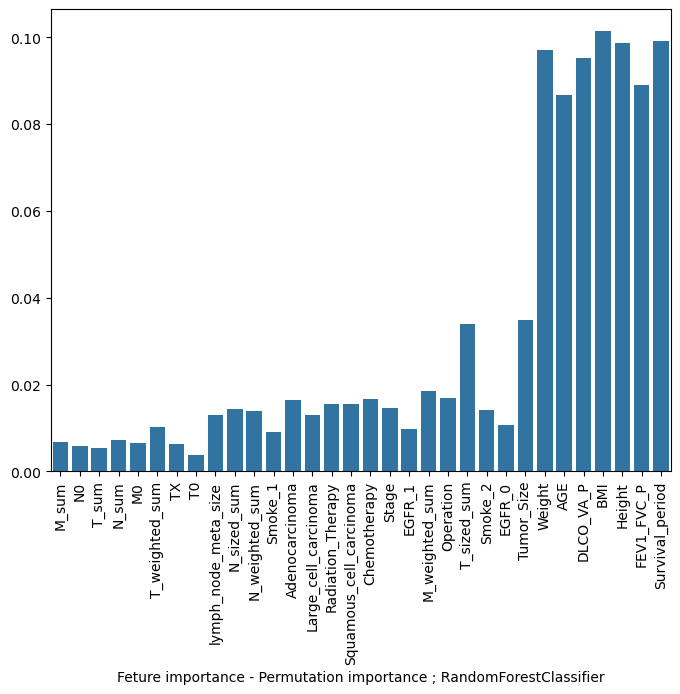

In [215]:
train_x_columns=train_C_x.columns[importance]
plt.figure(figsize=(8,6))
sns.barplot(x=train_x_columns, y=feature_importance[importance], )
plt.xticks(rotation=90)
plt.xlabel('Feture importance - Permutation importance ; RandomForestClassifier')
plt.show()

In [216]:
from sklearn.linear_model import LogisticRegression
lr_model= LogisticRegression()
lr_model.fit(train_C_x, train_C_y)

c:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [217]:
# 계수 출력
importance = lr_model.coef_[0]
for i, v in enumerate(importance):
    print(f'Feature: {train_C_x.columns[i]}, Score: {v}')

Feature: AGE, Score: 0.001206933911421034
Feature: Stage, Score: 0.0034678786999206676
Feature: Tumor_Size, Score: 0.0015980660457728195
Feature: lymph_node_meta_size, Score: 0.0028188551805838524
Feature: Adenocarcinoma, Score: 0.003172560733314815
Feature: Large_cell_carcinoma, Score: 0.009612765336794267
Feature: Squamous_cell_carcinoma, Score: -0.005937844503336151
Feature: TX, Score: 0.006790131215696788
Feature: T0, Score: -0.0069767367373818594
Feature: N0, Score: 0.002234928891206902
Feature: M0, Score: -0.0056098048085746356
Feature: Height, Score: -0.007743965718791276
Feature: Weight, Score: 0.007529743364277592
Feature: FEV1_FVC_P, Score: -0.0016603186850373305
Feature: DLCO_VA_P, Score: 0.0008429599023217482
Feature: Operation, Score: -0.015217248778786864
Feature: Chemotherapy, Score: 0.02029356420997395
Feature: Radiation_Therapy, Score: 0.009598830234704628
Feature: Survival_period, Score: -0.00025279835087357183
Feature: EGFR_0, Score: 0.039368301527885584
Feature: EGF

In [218]:
lr_model= LogisticRegression()
lr_model.fit(train_C_x, train_C_y)

# Feature Importance 가져오기
importance = lr_model.coef_[0]  # 계수 추출


c:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [219]:
importance

array([ 0.00120693,  0.00346788,  0.00159807,  0.00281886,  0.00317256,
        0.00961277, -0.00593784,  0.00679013, -0.00697674,  0.00223493,
       -0.0056098 , -0.00774397,  0.00752974, -0.00166032,  0.00084296,
       -0.01521725,  0.02029356,  0.00959883, -0.0002528 ,  0.0393683 ,
       -0.02592088, -0.02013339, -0.00089499,  0.00159807, -0.00369445,
       -0.0073084 ,  0.00379298, -0.00603633, -0.01172937,  0.00417937,
        0.01775336, -0.04807968])

In [220]:
odds_ratios = np.exp(importance)

# 각 변수의 odds ratio 출력
for feature, odds_ratio in zip(train_C_x.columns, odds_ratios):
    print(f"Feature: {feature}, Odds Ratio: {odds_ratio}")

Feature: AGE, Odds Ratio: 1.001207662549264
Feature: Stage, Odds Ratio: 1.0034738987481802
Feature: Tumor_Size, Odds Ratio: 1.0015993436337822
Feature: lymph_node_meta_size, Odds Ratio: 1.0028228318885584
Feature: Adenocarcinoma, Odds Ratio: 1.0031775986303875
Feature: Large_cell_carcinoma, Odds Ratio: 1.0096591163669792
Feature: Squamous_cell_carcinoma, Odds Ratio: 0.9940797496543212
Feature: TX, Odds Ratio: 1.0068132364228515
Feature: T0, Odds Ratio: 0.9930475441903416
Feature: N0, Odds Ratio: 1.002237428206365
Feature: M0, Odds Ratio: 0.994405900764297
Feature: Height, Odds Ratio: 0.9922859415336956
Feature: Weight, Odds Ratio: 1.0075581631683392
Feature: FEV1_FVC_P, Odds Ratio: 0.9983410588815254
Feature: DLCO_VA_P, Odds Ratio: 1.0008433152928733
Feature: Operation, Odds Ratio: 0.984897948482712
Feature: Chemotherapy, Odds Ratio: 1.020500878591905
Feature: Radiation_Therapy, Odds Ratio: 1.0096450467621478
Feature: Survival_period, Odds Ratio: 0.9997472335999371
Feature: EGFR_0, Odd

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15616\2767173690.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='odds_ratios', y='Feature', data=feature_importance1, palette='viridis')


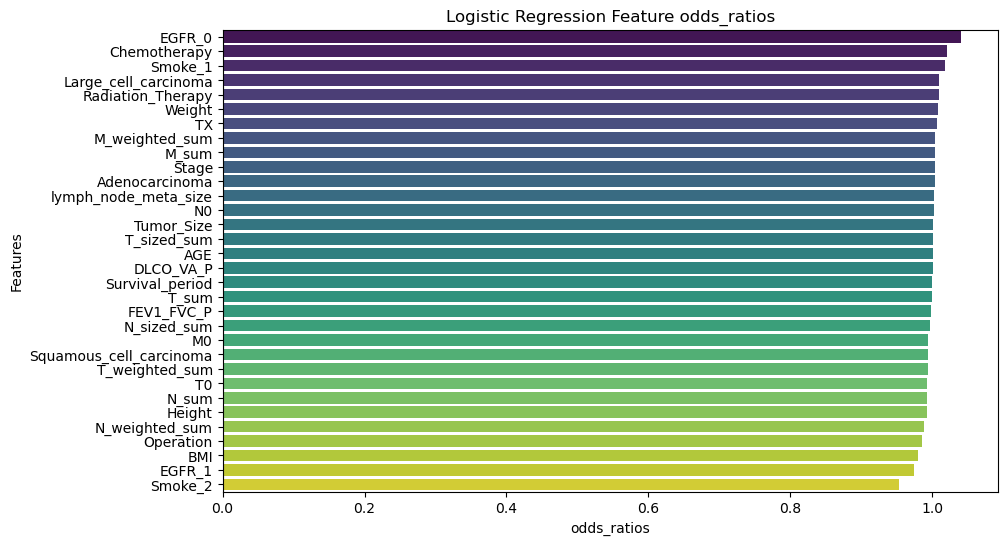

In [221]:

# DataFrame으로 정리
feature_importance1 = pd.DataFrame({
    'Feature': train_C_x.columns,
    'odds_ratios': odds_ratios
}).sort_values(by='odds_ratios', ascending=False)

# 그래프 그리기
plt.figure(figsize=(10, 6))
sns.barplot(x='odds_ratios', y='Feature', data=feature_importance1, palette='viridis')
plt.title('Logistic Regression Feature odds_ratios')
plt.xlabel('odds_ratios')
plt.ylabel('Features')
plt.axvline(x=0, color='gray', linestyle='--')  # 0을 기준선으로 표시
plt.show()

In [222]:
from sklearn.inspection import permutation_importance

result = permutation_importance(lr_model, train_C_x, train_C_y, n_repeats=10)
importance = result.importances_mean
print(importance)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [223]:

importance = result.importances_mean.argsort()
print(importance)



[ 0 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7
  6  5  4  3  2  1 30 31]


In [224]:
np.argsort(importance)

array([ 0, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14,
       13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1, 30, 31],
      dtype=int64)

In [157]:
sorted_idx =np.argsort(importance)

In [158]:
np.array(train_x_columns)[sorted_idx]

array(['M_sum', 'BMI', 'AGE', 'Weight', 'Tumor_Size', 'EGFR_0', 'Smoke_2',
       'T_sized_sum', 'Operation', 'M_weighted_sum', 'Stage', 'EGFR_1',
       'FEV1_FVC_P', 'Chemotherapy', 'DLCO_VA_P',
       'Squamous_cell_carcinoma', 'Large_cell_carcinoma', 'Smoke_1',
       'Adenocarcinoma', 'N_weighted_sum', 'N_sized_sum',
       'Survival_period', 'lymph_node_meta_size', 'TX', 'T0',
       'T_weighted_sum', 'M0', 'N_sum', 'T_sum', 'N0',
       'Radiation_Therapy', 'Height'], dtype=object)

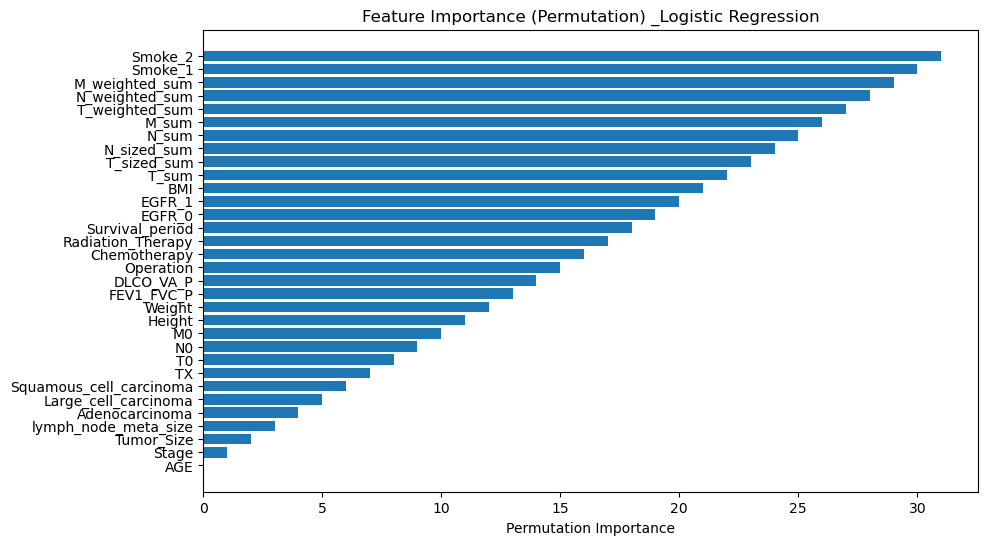

In [225]:
# feature importance와 feature 이름 준비
train_x_columns=train_C_x.columns[importance]# 입력 데이터의 컬럼 이름 가져오기
sorted_idx = np.argsort(importance)  # 중요도를 기준으로 정렬

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train_x_columns)[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance (Permutation) _Logistic Regression')
plt.show()

In [64]:
import sys
!{sys.executable} -m pip install xgboost

In [65]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [226]:
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(train_C_x, train_C_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [227]:


# Feature Importance 출력
importance = model.feature_importances_
print(importance)

[0.04237996 0.03987794 0.04037561 0.04475755 0.04097193 0.04721831
 0.04717554 0.03117605 0.05028365 0.         0.         0.04505245
 0.04380836 0.04321124 0.04276803 0.04288305 0.04266895 0.04514213
 0.04063009 0.04154623 0.05405986 0.0419645  0.         0.
 0.00963318 0.         0.         0.         0.         0.03765217
 0.04469411 0.04006908]


In [228]:
train_C_x.columns

Index(['AGE', 'Stage', 'Tumor_Size', 'lymph_node_meta_size', 'Adenocarcinoma',
       'Large_cell_carcinoma', 'Squamous_cell_carcinoma', 'TX', 'T0', 'N0',
       'M0', 'Height', 'Weight', 'FEV1_FVC_P', 'DLCO_VA_P', 'Operation',
       'Chemotherapy', 'Radiation_Therapy', 'Survival_period', 'EGFR_0',
       'EGFR_1', 'BMI', 'T_sum', 'T_sized_sum', 'N_sized_sum', 'N_sum',
       'M_sum', 'T_weighted_sum', 'N_weighted_sum', 'M_weighted_sum',
       'Smoke_1', 'Smoke_2'],
      dtype='object')

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15616\2811697407.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


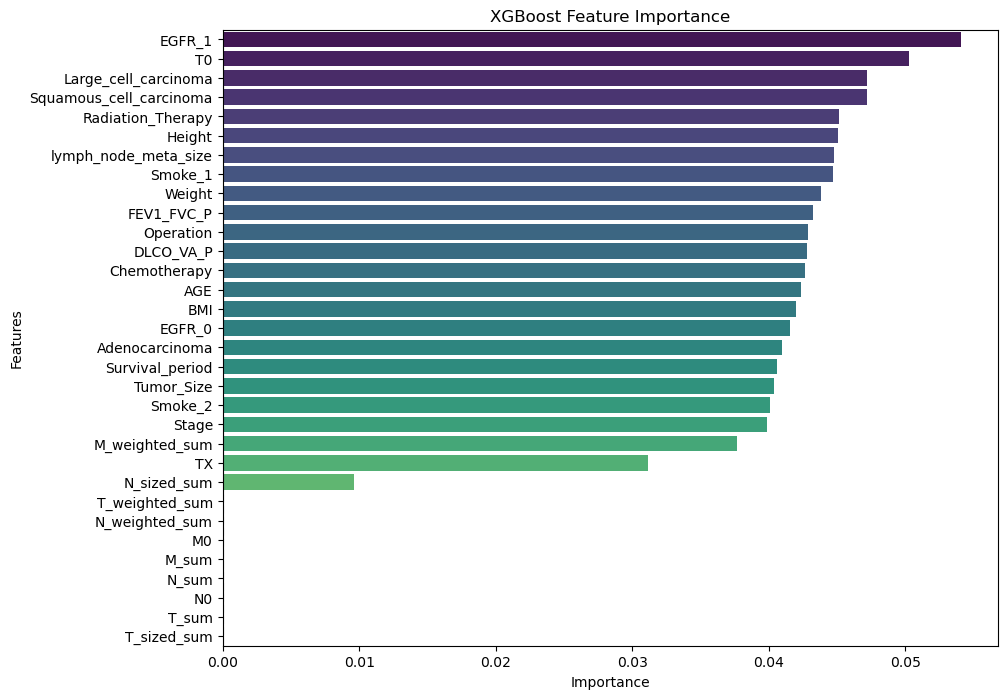

In [229]:
train_x_columns = train_C_x.columns

feature_importance = pd.DataFrame({
    'Feature': train_x_columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# 그래프 그리기
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.axvline(x=0, color='gray', linestyle='--')  # 0을 기준선으로 표시
plt.show()

In [230]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, train_C_x, train_C_y, n_repeats=10)
importance = result.importances_mean
print(importance)
importance = result.importances_mean.argsort()
print(importance)

[0.05331 0.01109 0.02639 0.01356 0.00686 0.00571 0.00854 0.00193 0.00115
 0.      0.      0.06471 0.07011 0.05573 0.05824 0.00762 0.00612 0.00766
 0.07735 0.00731 0.00524 0.06597 0.      0.      0.00225 0.      0.
 0.      0.      0.00823 0.00241 0.00729]
[28 27 26 25  9 10 23 22  8  7 24 30 20  5 16  4 31 19 15 17 29  6  1  3
  2  0 13 14 11 21 12 18]


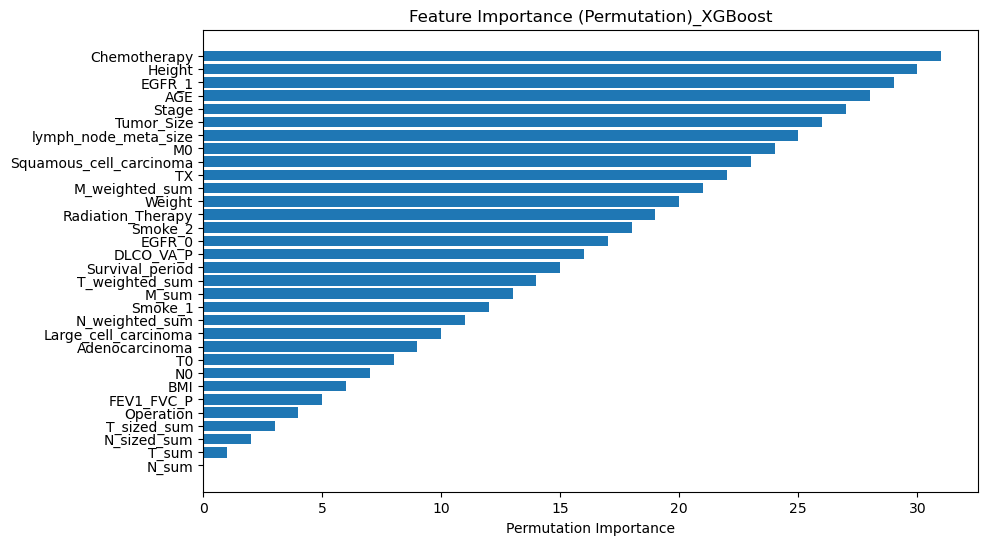

In [231]:
# feature importance와 feature 이름 준비
train_x_columns=train_C_x.columns # 입력 데이터의 컬럼 이름 가져오기
sorted_idx = np.argsort(importance)  # 중요도를 기준으로 정렬

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importance[sorted_idx], align='center')  # 중요도 값 사용
plt.yticks(range(len(sorted_idx)), np.array(train_x_columns)[sorted_idx])  # 정렬된 feature 이름
plt.xlabel('Permutation Importance')
plt.title('Feature Importance (Permutation)_XGBoost')
plt.show()

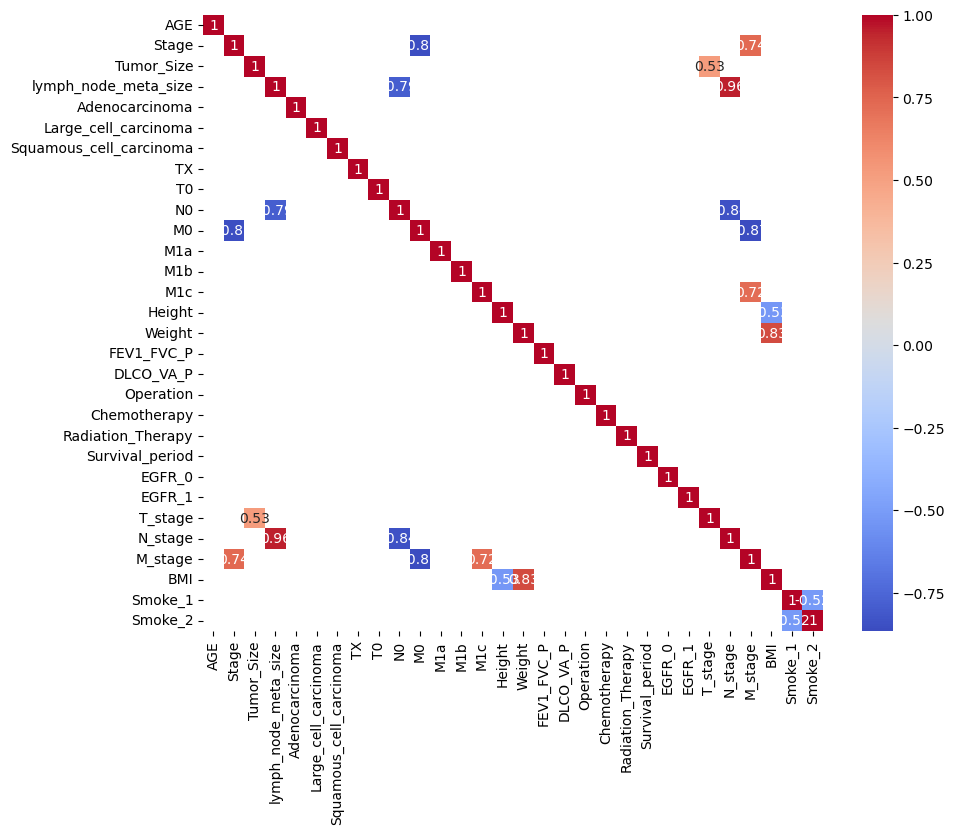

In [71]:

corr_matrix = df_all.drop(columns=['Death','T1a','T1b','T1c','T1','T2','T2a','T2b','T3','T4','N1','N2','N3','Drink_1',
                            'Drink_2','Drink_3','Drink_99','EGFR_99']).corr()
filtered_corr = corr_matrix[abs(corr_matrix) > 0.5]  # 예: |r| > 0.5만 표시
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm')
plt.show()

In [72]:
train_C_x

array([[0.6376404450088811, 1.0, -0.9259674082407238, ...,
        1.5770037579869978, False, True],
       [0.2257043587363468, 4.0, -0.09525558396036228, ...,
        -0.9882502894631057, False, True],
       [0.8436084881451482, 4.0, -0.9259674082407238, ...,
        0.15486338159475638, False, True],
       ...,
       [-2.1772561445201033, 1.0, -0.7182894521706333, ...,
        0.3469508382346108, False, True],
       [1.5301686319327055, 3.0, 2.604557844950812, ...,
        -0.5802940891689697, False, True],
       [-2.1772561445201033, 1.0, -0.9259674082407238, ...,
        -1.3579083383471307, False, False]], dtype=object)

In [73]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AGE                      15000 non-null  float64
 1   Stage                    15000 non-null  float64
 2   Tumor_Size               14989 non-null  float64
 3   lymph_node_meta_size     15000 non-null  float64
 4   Adenocarcinoma           15000 non-null  int64  
 5   Large_cell_carcinoma     15000 non-null  int64  
 6   Squamous_cell_carcinoma  15000 non-null  int64  
 7   TX                       15000 non-null  int64  
 8   T0                       15000 non-null  int64  
 9   T1                       15000 non-null  int64  
 10  T1a                      15000 non-null  int64  
 11  T1b                      15000 non-null  int64  
 12  T1c                      15000 non-null  int64  
 13  T2                       15000 non-null  int64  
 14  T2a                   

In [74]:
numeric_data.isna().sum()

NameError: name 'numeric_data' is not defined

In [67]:
#df_test.drop(columns='Death', axis=1).columns[sorted_idx]

In [205]:
rf_model2 = RandomForestRegressor(n_estimators=100, random_state=42)

In [206]:
rf_model2.fit(train_R_x, train_R_y)
y_pred2 = rf_model2.predict(test_R_x)
rf_model2.score(test_R_x, test_R_y) # r2 값과 동일

-0.03765126662055307

In [207]:
#feature importance 계산해보기 (모델의 특성이 얼마나 예측에 중요한지 확인해보기)
feature_importance2 = rf_model2.feature_importances_

sorted_idx2 = feature_importance2.argsort()
print(sorted_idx2)

[16 15 20 14 12 17  7 21 44 13 19 42  6 43 39 11 24 37 10 18 22 35  9 23
 34  8 41 36 33  4 40 38  2  5 32  3 31 30 25  1  0 28 29 26 27]


In [208]:
# R squre, MSE, MAE로 성능 지표 확인
mse2 = mean_squared_error(test_R_y, y_pred2)
r2_2 = r2_score(test_R_y, y_pred2)
mae2 = mean_absolute_error(test_R_y,y_pred2)

print('MAE :', mae2)
print('MSE :',mse2)
print('R2 :', r2_2)

MAE : 155.01560600000002
MSE : 34523.2795983
R2 : -0.03765126662055307


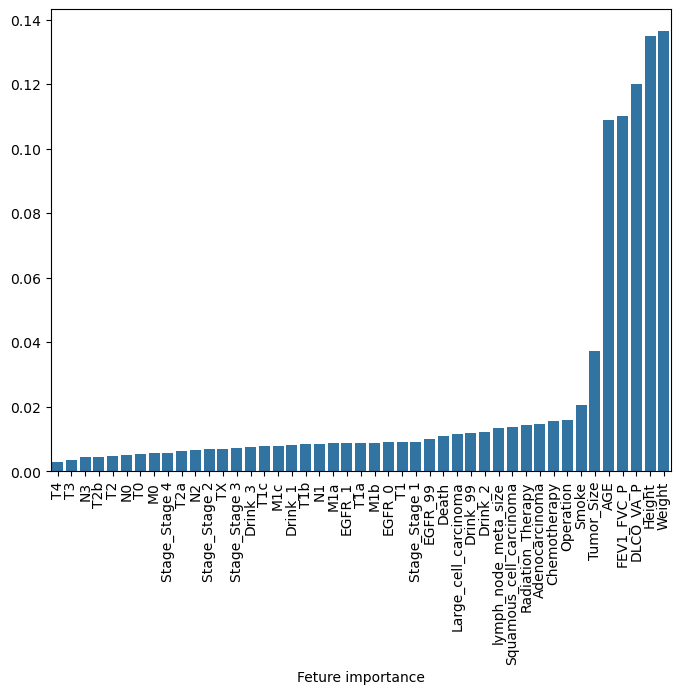

In [209]:
train_x_columns2=df_test.drop(columns='Survival_period', axis=1).columns[sorted_idx2]
plt.figure(figsize=(8,6))
sns.barplot(x=train_x_columns2, y=feature_importance2[sorted_idx2], )
plt.xticks(rotation=90)
plt.xlabel('Feture importance')
plt.show()

<Axes: >

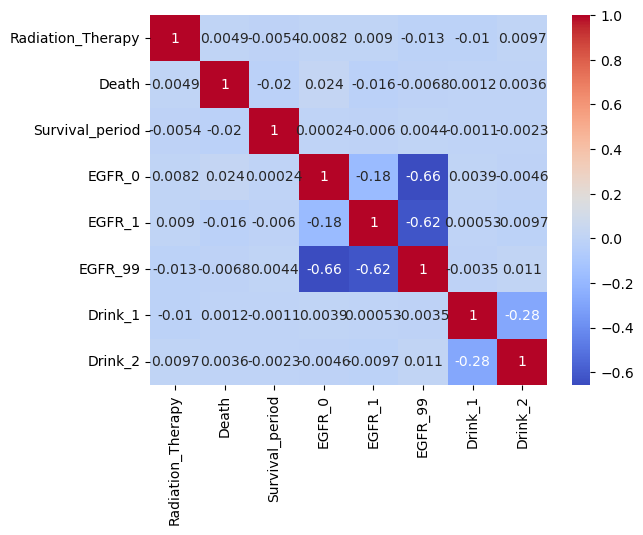

In [73]:
sns.heatmap(data=df.iloc[:,30:38].corr(),cmap='coolwarm', annot=True)

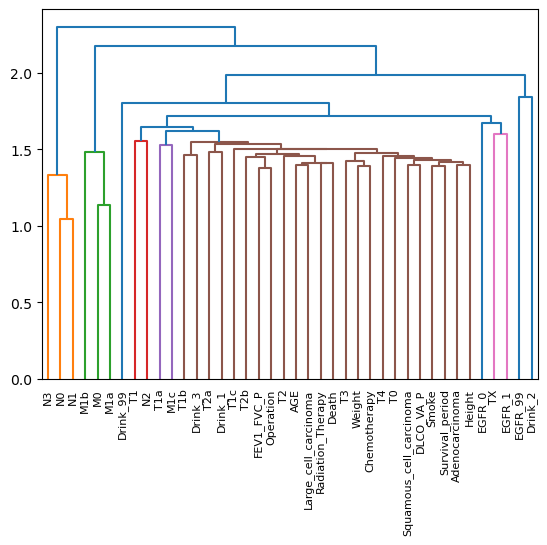

In [74]:
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.cluster.hierarchy as sch

# 군집화
linked = linkage(df.corr(), method='ward')
dendrogram(linked, labels=df.corr().columns, orientation='top')
plt.xticks(rotation=90)
plt.show()

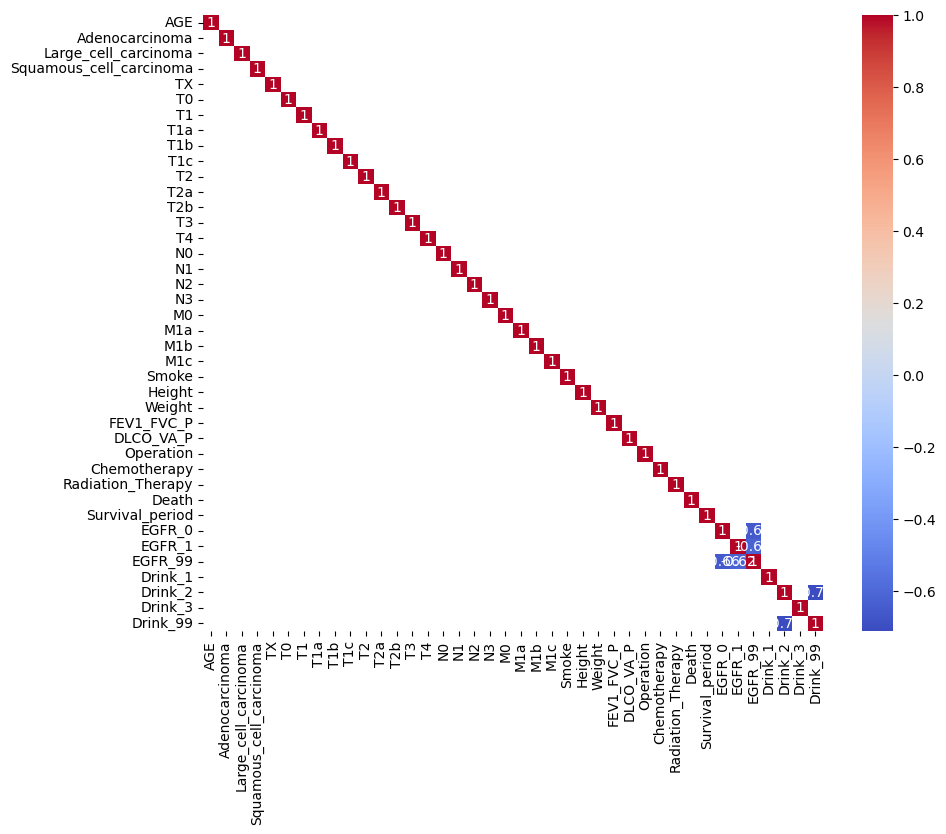

In [75]:
corr_matrix = df.corr()
filtered_corr = corr_matrix[abs(corr_matrix) > 0.6]  # 예: |r| > 0.5만 표시
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm')
plt.show()